<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Для оператора такси нужно предсказать количество заказов на следующий час.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

Изучим предоставленные данные.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(df.sample(10))
df.info()

                     num_orders
datetime                       
2018-07-28 07:20:00           1
2018-05-07 18:10:00           9
2018-08-27 01:30:00          35
2018-05-13 06:30:00           8
2018-06-27 05:50:00           3
2018-06-28 01:00:00          21
2018-03-11 17:10:00           6
2018-03-30 19:30:00          11
2018-08-27 02:40:00          34
2018-07-03 21:00:00          10
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

## Анализ

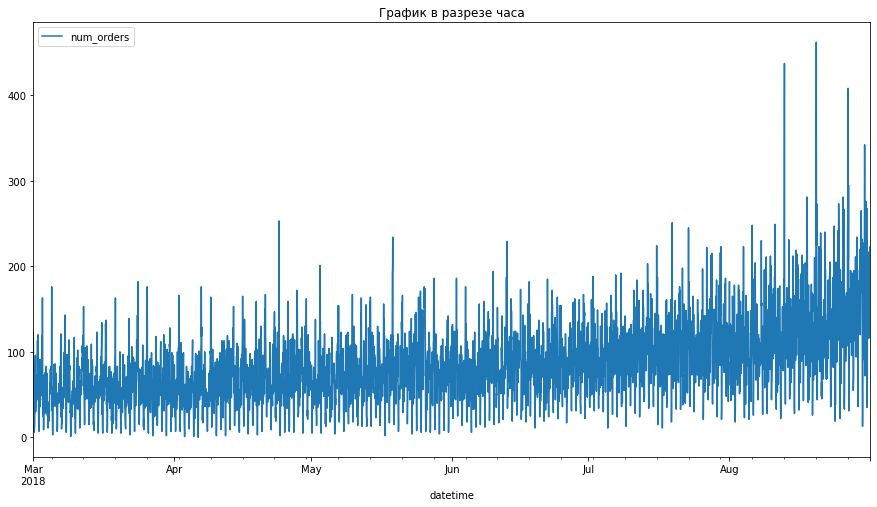

In [4]:
fig = df.plot(figsize = (15, 8), title = "График в разрезе часа")

<AxesSubplot:title={'center':'График в разрезе дня'}, xlabel='datetime'>

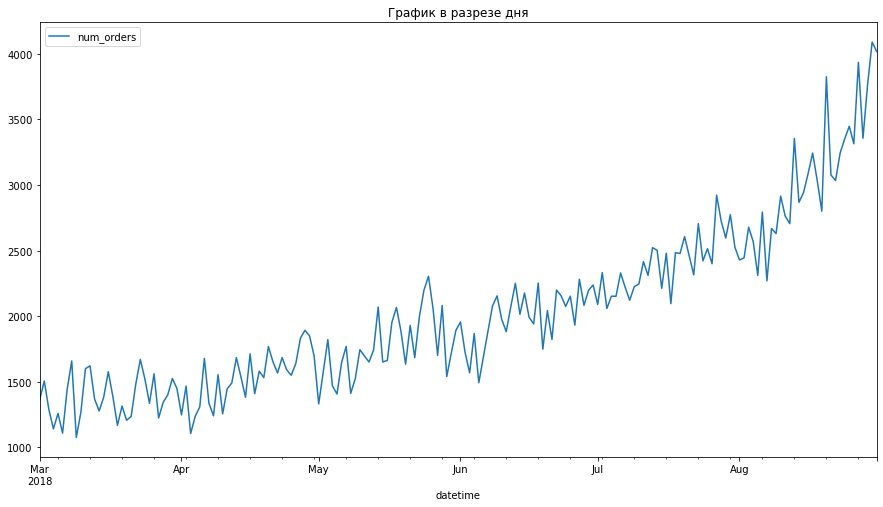

In [5]:
df.resample('1D').sum().plot(figsize = (15, 8), title = "График в разрезе дня")

Мы видим сильные колебания на графике ряда после ресемплирования в разрезе часа. При ресемплировании в разрезе дня колебаний меньше и начинает прослеживаться восходящий тренд.

<AxesSubplot:xlabel='datetime'>

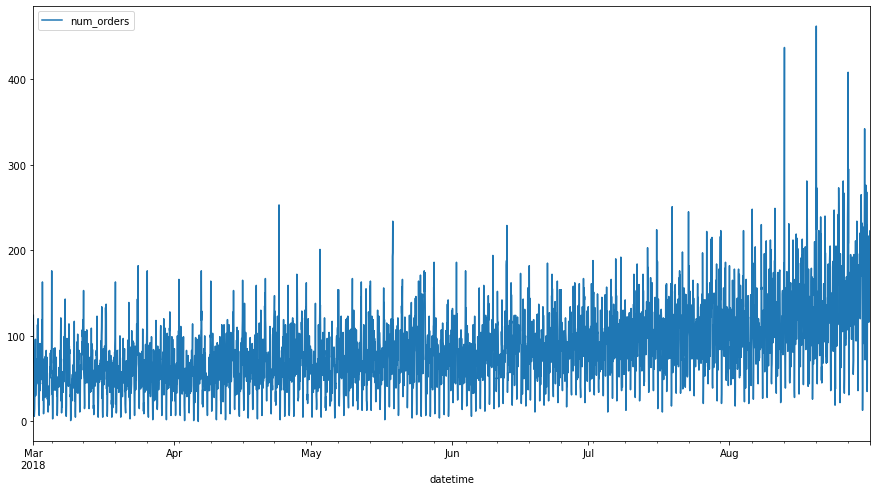

In [6]:
df.plot(figsize = (15, 8))

Мы все еще видим высокие колебания на графике. 

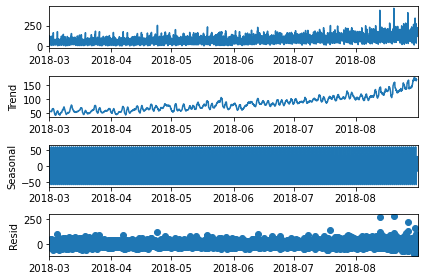

In [7]:
decomposed = seasonal_decompose(df)
fig = decomposed.plot()

Рассмотрим график сезонности за более краткие периоды (один месяц, одна неделя, день) для наглядности.

<AxesSubplot:title={'center':'График сезонности за 1-2 августа 2018'}, xlabel='datetime'>

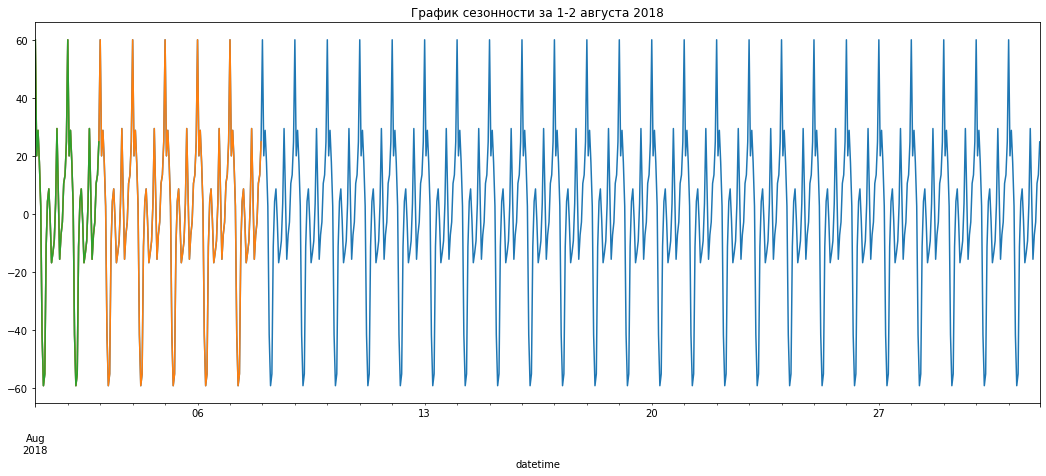

In [8]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(figsize = (18, 7), title='График сезонности за август 2018')
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(figsize = (18, 7), title='График сезонности за первую неделю августа 2018')
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(figsize = (18, 7), title='График сезонности за 1-2 августа 2018')

Мы видим повторяющиеся значения, при этом период повтора составляет 24 часа. Пик заказов - 12 часов ночи, второй пик - 17:00. Минимум - 6 часов утра. 

Для уменьшения колебаний на графике и просмотра тренда вычислим скользящее среднее. Для этого возьмем окно в 100 значений. 

<AxesSubplot:xlabel='datetime'>

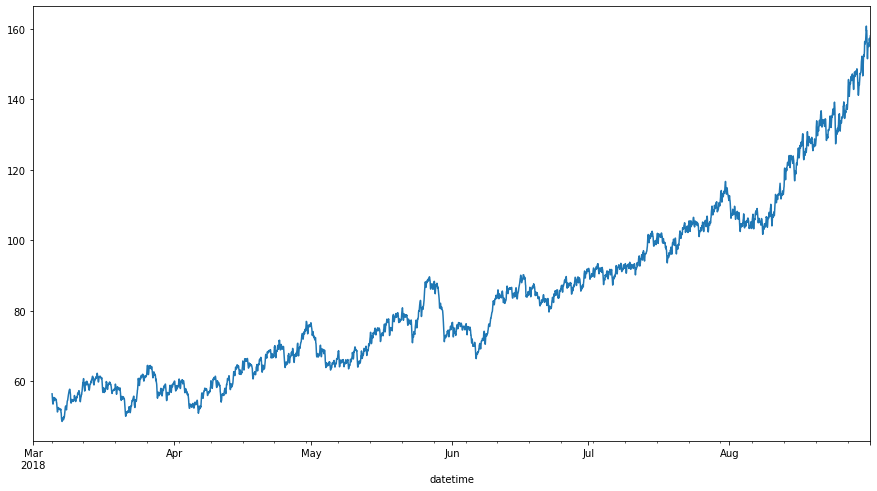

In [9]:
df['rolling_mean'] = df.rolling(100).mean() 
df['rolling_mean'].plot(figsize=(15, 8))

На графике явно виден восходящий тренд. Количество продаж возрастает.

## Обучение

Разделим данные на обучающую и тестовую выборки. Протестируем разные модели и подберем оптимальный размер окна для скользащего среднего.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

# Функция подбирает лучшие параметры скользящего среднего
# параметр max_lag возьмем 24 - относительно сезонности
def df_params_selection(model, df, model_name):
    
    best_rmse = 1000000
    best_roll_size = 0
    
    for j in range(1, 10):
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()

        target_train = train['num_orders']
        features_train = train.drop('num_orders', axis=1)
        target_test = test['num_orders']
        features_test = test.drop('num_orders', axis=1)
    
        make_features(df, 24, j)
        model.fit(features_train, target_train)
        pred_test = model.predict(features_test)
    
        rmse = np.sqrt(mean_squared_error(target_test, pred_test))
        
        if rmse<best_rmse:
            best_rmse = rmse
            best_roll_size = j
            
    print('Для', model_name, 'лучшее RMSE =',best_rmse)
    print('Для', model_name, 'лучший параметр best_roll_size =',best_roll_size)

    

model_lr = LinearRegression()
model_lgbm = LGBMRegressor()
model_xgb = xgb.XGBClassifier()
model_rfr = RandomForestRegressor()

'''df_params_selection(model_lr, df, 'linear_regression')
df_params_selection(model_lgbm, df, 'LGBMRegressor')
df_params_selection(model_xgb, df, 'XGBClassifier')
df_params_selection(model_rfr, df, 'RandomForestRegressor')'''

"df_params_selection(model_lr, df, 'linear_regression')\ndf_params_selection(model_lgbm, df, 'LGBMRegressor')\ndf_params_selection(model_xgb, df, 'XGBClassifier')\ndf_params_selection(model_rfr, df, 'RandomForestRegressor')"

Лучшие значения показала модель LGBMRegressor. Подберем гиперпараметры модели, добавим скользящее среднее по величине оптимального окна для модели LGBMRegressor.

In [11]:
df['rolling_mean'] = df['num_orders'].shift().rolling(7).mean()
df.dropna()
df.sample(5)

,num_orders,rolling_mean
datetime,,
2018-04-18 05:00:00,15,72.571429
2018-08-01 15:00:00,113,87.857143
2018-07-22 03:00:00,128,109.142857
2018-08-19 20:00:00,116,136.857143
2018-04-06 11:00:00,101,41.428571


In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

params = {
    'num_leaves': [7, 14, 21],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 300],
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model_lgbm, cv=tscv, param_grid=params, scoring = 'neg_mean_squared_error')
gsearch.fit(features_train, target_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [13]:
print(gsearch.best_estimator_)

LGBMRegressor(learning_rate=0.03, max_depth=3, num_leaves=14)


Мы нашли лучшие гиперпараметры для модели LGBMRegressor.

## Тестирование

In [15]:
model = LGBMRegressor(random_state=12345, num_leaves = 14, learning_rate = 0.03, max_depth = 3, n_estimators = 300)
model.fit(features_train, target_train)
pred = model.predict(features_test)
rmse = (np.sqrt(mean_squared_error(target_test, pred)))
print('RMSE: {:.2f}'.format(rmse))

features_test

RMSE: 70.07


,rolling_mean
datetime,
2018-08-13 14:00:00,111.142857
2018-08-13 15:00:00,120.142857
2018-08-13 16:00:00,132.142857
2018-08-13 17:00:00,133.142857
2018-08-13 18:00:00,132.571429
...,...
2018-08-31 19:00:00,167.428571
2018-08-31 20:00:00,167.428571
2018-08-31 21:00:00,165.714286


Модель LGBMRegressor с лучшими параметрами показала результат целевой метрики RMSE = 70.07